# Data Parameters
(Basically, this will be deleted, as we keep iterating on this until we can get the next checkpoint)

Input

- Frames: 5 in 1 out
- Target: 1 station (LA N. Main St.)
- Channels: AirNow, Wind U/V
- Temporal data (Months, Weekdays, Days, Hours)

Model
- See "Architecture"

Result

In [1]:
import os
# Suppress TensorFlow logging (2 = ERROR only, 3 = no logs)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['TF_CPP_VMODULE'] = ''

# Suppress XLA/CUDA warnings
os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/usr/local/cuda'

import tensorflow as tf
# file locations
# for libs.plotting
import sys
sys.path.append("/workspace/notebooks")  # Changed from /workspace

# for the model checkpoint callback (if enabled)
model_checkpoint_file = '/workspace/notebooks/experiment_output/basic_experiments/model.keras'

# where the training data is stored
data_path = "/workspace/notebooks/pwwb-experiments/tensorflow/final_input_data/two_years_with_hrrr/"

# Data parameters
START_DATE = "2022-12-01-00"
END_DATE = "2024-12-01-00"

# Define bounding box
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)

# Input data shape
dim = 40
frames_per_sample = 5
EPOCHS = 100
BATCH_SIZE = 32
FORCE_CPU = False

print(f"{extent}")
print(f"Grid dimension: {dim}x{dim}")
print(f"Frames per sample: {frames_per_sample}")

2025-07-26 17:57:41.537391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-07-26 17:57:41.549996: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8473] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-07-26 17:57:41.554062: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1471] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


(-118.75, -117.0, 33.5, 34.5)
Grid dimension: 40x40
Frames per sample: 5


In [2]:
import os

print("Current directory:", os.getcwd())

print("\nData path exists:", os.path.exists(data_path))

if os.path.exists(data_path):
    files = os.listdir(data_path)
    print(f"\nFiles in {data_path}:")
    for f in files[:10]:  # Show first 10 files
        print(f"  - {f}")
else:
    print("\nSearching for data files...")
    for root, dirs, files in os.walk("/tf/notebooks"):
        if "AirNow_PM25_X_train.npy" in files:
            print(f"Found data at: {root}")
            break

Current directory: /workspace/notebooks/pwwb-experiments/tensorflow/temporal_encoding_model_archive

Data path exists: True

Files in /workspace/notebooks/pwwb-experiments/tensorflow/final_input_data/two_years_with_hrrr/:
  - Y_train.npy
  - Y_test.npy:Zone.Identifier
  - Y_valid.npy
  - Y_train.npy:Zone.Identifier
  - METAR_Wind_V_X_valid.npy
  - AirNow_PM25_X_valid.npy
  - METAR_Wind_U_X_test.npy
  - METAR_Wind_V_X_train.npy:Zone.Identifier
  - METAR_Wind_V_X_test.npy
  - AirNow_PM25_X_test.npy


In [3]:
import tensorflow as tf

# Force TensorFlow to use GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Force GPU to be used
    tf.config.set_visible_devices(gpus[0], 'GPU')
    print(f"Forcing GPU: {gpus[0]}")
    
    # Optional: Set memory growth to avoid OOM errors
    tf.config.experimental.set_memory_growth(gpus[0], True)
else:
    print("No GPU found!")
    
# Verify GPU is being used
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU Available:", tf.test.is_gpu_available())

Forcing GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Built with CUDA: True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available: True


I0000 00:00:1753552664.176261    8118 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1753552664.300041    8118 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1753552664.300103    8118 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1753552664.330152    8118 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1753552664.330217    8118 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

# Data Ingestion and Preprocessing

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
from datetime import datetime

#from libs.sequence import PWWBPyDataset

In [5]:
'''
X_test_files =  ["AirNow_PM25_X_test.npy", "HRRR_COLMD_X_test.npy", "MAIAC_AOD_X_test.npy", "METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy", "TROPOMI_NO2_X_test.npy"]
X_train_files = ["AirNow_PM25_X_train.npy", "HRRR_COLMD_X_train.npy", "MAIAC_AOD_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy", "TROPOMI_NO2_X_train.npy"]
X_valid_files = ["AirNow_PM25_X_valid.npy", "HRRR_COLMD_X_valid.npy", "MAIAC_AOD_X_valid.npy", "METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy", "TROPOMI_NO2_X_valid.npy"]
'''
X_test_files =  ["AirNow_PM25_X_test.npy", "METAR_Wind_U_X_test.npy", "METAR_Wind_V_X_test.npy"]
X_train_files = ["AirNow_PM25_X_train.npy", "METAR_Wind_U_X_train.npy", "METAR_Wind_V_X_train.npy"]
X_valid_files = ["AirNow_PM25_X_valid.npy", "METAR_Wind_U_X_valid.npy", "METAR_Wind_V_X_valid.npy"]

Y_test_files = "Y_test.npy"
Y_train_files = "Y_train.npy"
Y_valid_files = "Y_valid.npy"

In [6]:
''' y is not trimmed, can't use this method
BATCH_SIZE = 32
X_training_files_paths = [f"{data_path + file}" for file in X_train_files]
Y_training_files_paths = f"{data_path + Y_train_files}"
generator = PWWBPyDataset(X_training_files_paths, Y_training_files_paths, BATCH_SIZE, workers=8, use_multiprocessing=True)

history = seq.fit(
    generator,
    epochs=EPOCHS,
    validation_data=(X_valid_scaled, Y_valid),
    callbacks=callbacks
)
'''
X_train = np.stack([np.load(f"{data_path + file}") for file in X_train_files], axis=-1)
X_test = np.stack([np.load(f"{data_path + file}") for file in X_test_files], axis=-1)
X_valid = np.stack([np.load(f"{data_path + file}") for file in X_valid_files], axis=-1)

Y_train = np.load(f"{data_path + Y_train_files}")
Y_test = np.load(f"{data_path + Y_test_files}")
Y_valid = np.load(f"{data_path + Y_valid_files}")

In [7]:
X_train_2 = np.load(f"{data_path}Temporal_Encoding_X_train.npy")
X_test_2 = np.load(f"{data_path}Temporal_Encoding_X_test.npy")
X_valid_2 = np.load(f"{data_path}Temporal_Encoding_X_valid.npy")

# Add Cyclical Hour Encoding

## Problem with Linear Hour Encoding (or One-Hot Encoding)

Traditional encoding methods create artificial discontinuities:

### One-Hot Encoding Issue:
```
11 PM (hour 23): [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1]
Midnight (hr 0): [1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
```
- These vectors are maximally different (no overlap)
- But 11 PM and midnight are only 1 hour apart!

### Linear Encoding Issue:
- Hour 23 (11 PM) = 23
- Hour 0 (12 AM) = 0
- Distance = 23 (maximum possible)
- But temporally, they are adjacent

## Solution: Cyclical Encoding

Transform hours into sine and cosine components that wrap around a circle:
- `hour_sin = sin(2π * hour / 24)`
- `hour_cos = cos(2π * hour / 24)`

This ensures:
- 11 PM (hour 23) and 12 AM (hour 0) are close in the feature space
- Smooth transitions between all adjacent hours
- No artificial "jump" at midnight
- Better captures the cyclical nature of daily patterns

## Why This Matters for Air Quality

PM2.5 concentrations often follow daily cycles:
- Rush hour peaks
- Overnight minimums
- Temperature-driven patterns

The model needs to understand that 11 PM patterns naturally flow into 12 AM patterns, which cyclical encoding provides.


In [8]:
import numpy as np
import pandas as pd

print("Original temporal encoding shape:", X_train_2.shape)

# Generate timestamps for the entire dataset
timestamps = pd.date_range(start=START_DATE, end=END_DATE, freq='h')

# Calculate where each dataset starts
n_train = len(X_train_2)
n_valid = len(X_valid_2)
n_test = len(X_test_2)

def create_cyclical_only_encoding(X_temporal, start_idx, timestamps, frames_per_sample=5):
    """
    Create a new temporal encoding with ONLY cyclical features.
    This replaces one-hot encoding with efficient sin/cos encoding.
    """
    n_samples = X_temporal.shape[0]
    
    # Only 6 features: 3 temporal dimensions × 2 (sin & cos)
    n_features = 6
    
    X_temporal_new = np.zeros((n_samples, frames_per_sample, n_features))
    
    for i in range(n_samples):
        sample_timestamps = timestamps[start_idx + i : start_idx + i + frames_per_sample]
        
        # Hour encoding (24-hour cycle) - Daily patterns
        hours = sample_timestamps.hour
        X_temporal_new[i, :, 0] = np.sin(2 * np.pi * hours / 24)
        X_temporal_new[i, :, 1] = np.cos(2 * np.pi * hours / 24)
        
        # Day of week encoding (7-day cycle) - Weekly patterns
        day_of_week = sample_timestamps.dayofweek  # 0=Monday, 6=Sunday
        X_temporal_new[i, :, 2] = np.sin(2 * np.pi * day_of_week / 7)
        X_temporal_new[i, :, 3] = np.cos(2 * np.pi * day_of_week / 7)
        
        # Month encoding (12-month cycle) - Seasonal patterns
        months = sample_timestamps.month
        X_temporal_new[i, :, 4] = np.sin(2 * np.pi * months / 12)
        X_temporal_new[i, :, 5] = np.cos(2 * np.pi * months / 12)
    
    return X_temporal_new

# Replace the old encoding with clean cyclical encoding
X_train_2 = create_cyclical_only_encoding(X_train_2, 0, timestamps, frames_per_sample)
X_valid_2 = create_cyclical_only_encoding(X_valid_2, n_train, timestamps, frames_per_sample)
X_test_2 = create_cyclical_only_encoding(X_test_2, n_train + n_valid, timestamps, frames_per_sample)

print("\nNew temporal encoding shapes (cyclical only):")
print(f"X_train_2: {X_train_2.shape}")
print(f"X_valid_2: {X_valid_2.shape}")
print(f"X_test_2: {X_test_2.shape}")

# Feature reference
print("\nFeature mapping:")
print("Feature 0: hour_sin")
print("Feature 1: hour_cos")
print("Feature 2: day_of_week_sin")
print("Feature 3: day_of_week_cos")
print("Feature 4: month_sin")
print("Feature 5: month_cos")

# Verify with a sample
print("\nSample verification (first timestamp):")
first_timestamp = timestamps[0]
print(f"Timestamp: {first_timestamp}")
print(f"Hour: {first_timestamp.hour} -> sin: {X_train_2[0, 0, 0]:.4f}, cos: {X_train_2[0, 0, 1]:.4f}")
print(f"Day of week: {first_timestamp.dayofweek} -> sin: {X_train_2[0, 0, 2]:.4f}, cos: {X_train_2[0, 0, 3]:.4f}")
print(f"Month: {first_timestamp.month} -> sin: {X_train_2[0, 0, 4]:.4f}, cos: {X_train_2[0, 0, 5]:.4f}")

Original temporal encoding shape: (12274, 5, 74)

New temporal encoding shapes (cyclical only):
X_train_2: (12274, 5, 6)
X_valid_2: (2630, 5, 6)
X_test_2: (2631, 5, 6)

Feature mapping:
Feature 0: hour_sin
Feature 1: hour_cos
Feature 2: day_of_week_sin
Feature 3: day_of_week_cos
Feature 4: month_sin
Feature 5: month_cos

Sample verification (first timestamp):
Timestamp: 2022-12-01 00:00:00
Hour: 0 -> sin: 0.0000, cos: 1.0000
Day of week: 3 -> sin: 0.4339, cos: -0.9010
Month: 12 -> sin: -0.0000, cos: 1.0000


In [9]:
# Verify the cyclical hour encoding
print("\n=== Verification of Cyclical Hour Encoding ===\n")

# Check a few samples from each dataset
def verify_cyclical_encoding(X_temporal, start_idx, timestamps, dataset_name, n_samples_to_check=3):
    print(f"\n{dataset_name}:")
    print("-" * 50)
    
    n_features_original = X_temporal.shape[2] - 2  # Last 2 are the new features
    
    for sample_idx in range(min(n_samples_to_check, len(X_temporal))):
        print(f"\nSample {sample_idx}:")
        
        # Get the timestamps for this sample
        sample_timestamps = timestamps[start_idx + sample_idx : start_idx + sample_idx + frames_per_sample]
        hours = sample_timestamps.hour
        
        # Get the encoded values
        hour_sin = X_temporal[sample_idx, :, -2]  # Second to last feature
        hour_cos = X_temporal[sample_idx, :, -1]  # Last feature
        
        # Calculate expected values
        expected_sin = np.sin(2 * np.pi * hours / 24)
        expected_cos = np.cos(2 * np.pi * hours / 24)
        
        print(f"  Timestamps: {sample_timestamps.strftime('%Y-%m-%d %H:%M').tolist()}")
        print(f"  Hours: {hours.tolist()}")
        print(f"  Hour sin: {hour_sin}")
        print(f"  Expected sin: {expected_sin}")
        print(f"  Hour cos: {hour_cos}")
        print(f"  Expected cos: {expected_cos}")
        print(f"  Sin match: {np.allclose(hour_sin, expected_sin)}")
        print(f"  Cos match: {np.allclose(hour_cos, expected_cos)}")

# Verify each dataset
verify_cyclical_encoding(X_train_2, 0, timestamps, "Training Set")
verify_cyclical_encoding(X_valid_2, n_train, timestamps, "Validation Set")
verify_cyclical_encoding(X_test_2, n_train + n_valid, timestamps, "Test Set")

# Additional check: verify the cyclical properties
print("\n=== Cyclical Properties Check ===")
print("\nChecking that sin²(θ) + cos²(θ) = 1 for all hours:")

for X_temporal, dataset_name in [(X_train_2, "Train"), (X_valid_2, "Valid"), (X_test_2, "Test")]:
    hour_sin = X_temporal[:, :, -2]
    hour_cos = X_temporal[:, :, -1]
    sum_of_squares = hour_sin**2 + hour_cos**2
    
    print(f"\n{dataset_name}:")
    print(f"  Min sum of squares: {sum_of_squares.min():.6f}")
    print(f"  Max sum of squares: {sum_of_squares.max():.6f}")
    print(f"  Mean sum of squares: {sum_of_squares.mean():.6f}")
    print(f"  All close to 1: {np.allclose(sum_of_squares, 1.0)}")

# Check continuity at day boundaries
print("\n=== Continuity Check at Day Boundaries ===")
print("\nChecking encoding at midnight (hour 0) and 11 PM (hour 23):")

# Hour 0 (midnight)
sin_0 = np.sin(2 * np.pi * 0 / 24)
cos_0 = np.cos(2 * np.pi * 0 / 24)
print(f"Hour 0:  sin={sin_0:.4f}, cos={cos_0:.4f}")

# Hour 23
sin_23 = np.sin(2 * np.pi * 23 / 24)
cos_23 = np.cos(2 * np.pi * 23 / 24)
print(f"Hour 23: sin={sin_23:.4f}, cos={cos_23:.4f}")

# Hour 1 (for comparison)
sin_1 = np.sin(2 * np.pi * 1 / 24)
cos_1 = np.cos(2 * np.pi * 1 / 24)
print(f"Hour 1:  sin={sin_1:.4f}, cos={cos_1:.4f}")

print("\nNote: The encoding should be continuous, with hour 23 values close to hour 0 values")


=== Verification of Cyclical Hour Encoding ===


Training Set:
--------------------------------------------------

Sample 0:
  Timestamps: ['2022-12-01 00:00', '2022-12-01 01:00', '2022-12-01 02:00', '2022-12-01 03:00', '2022-12-01 04:00']
  Hours: [0, 1, 2, 3, 4]
  Hour sin: [-2.4492936e-16 -2.4492936e-16 -2.4492936e-16 -2.4492936e-16
 -2.4492936e-16]
  Expected sin: Index([                0.0, 0.25881904510252074, 0.49999999999999994,
        0.7071067811865475,  0.8660254037844386],
      dtype='float64')
  Hour cos: [1. 1. 1. 1. 1.]
  Expected cos: Index([               1.0, 0.9659258262890683, 0.8660254037844387,
       0.7071067811865476, 0.5000000000000001],
      dtype='float64')
  Sin match: False
  Cos match: False

Sample 1:
  Timestamps: ['2022-12-01 01:00', '2022-12-01 02:00', '2022-12-01 03:00', '2022-12-01 04:00', '2022-12-01 05:00']
  Hours: [1, 2, 3, 4, 5]
  Hour sin: [-2.4492936e-16 -2.4492936e-16 -2.4492936e-16 -2.4492936e-16
 -2.4492936e-16]
  Expected sin: Index([

In [10]:
# 5 frames in, one frame and one station out
# next frame = 0 (:1)
# LA station = 4, Compton = 5
sensors = [
    'Simi Valley - Cochran Street', 'Reseda', 'Santa Clarita', 'North Holywood', 'Los Angeles - N. Main Street', 
    'Compton', 'Long Beach Signal Hill', 'Anaheim', 'Glendora - Laurel', 'Mira Loma - Van Buren', 
    'Riverside - Rubidoux', 'Lake Elsinore - W. Flint Street', 'Crestline - Lake Gregory', 
    'Temecula (Lake Skinner)', 'Fontana - Arrow Highway', 'EBAM-2'
]
sensor = {location : i for i, location in enumerate(sensors)}
sensor_names = ['Long Beach Signal Hill']

Y_train = Y_train[:, :1, [sensor['Los Angeles - N. Main Street']]].copy()
Y_test = Y_test[:, :1, [sensor['Los Angeles - N. Main Street']]].copy()
Y_valid = Y_valid[:, :1, [sensor['Los Angeles - N. Main Street']]].copy()

# Model Definition

## Architecture

In [11]:
output_frames, output_stations = Y_train.shape[1:]
input_shape_1 = X_train.shape[1:] # (frames, height, width, channels)
input_shape_2 = X_train_2.shape[1:] # (frames, encoded time)

print(
    "Frame data input\n"
    f"X_train shape: {X_train.shape}\n"
    f"Y_train shape: {Y_train.shape}\n\n"
    
    f"X_test shape:  {X_test.shape}\n"
    f"Y_test shape:  {Y_test.shape}\n\n"

    f"X_valid shape: {X_valid.shape}\n"
    f"Y_valid shape: {Y_valid.shape}\n\n"

    f"Input shape:   {input_shape_1}\n"
    f"Output shape:  ({output_frames}, {output_stations})\n"
)

print(
    "Temporal data input\n"
    f"X_train shape: {X_train_2.shape}\n"
    
    f"X_test shape:  {X_test_2.shape}\n"

    f"X_valid shape: {X_valid_2.shape}\n"

    f"Input shape:   {input_shape_2}\n"
)

Frame data input
X_train shape: (12274, 5, 40, 40, 3)
Y_train shape: (12274, 1, 1)

X_test shape:  (2631, 5, 40, 40, 3)
Y_test shape:  (2631, 1, 1)

X_valid shape: (2630, 5, 40, 40, 3)
Y_valid shape: (2630, 1, 1)

Input shape:   (5, 40, 40, 3)
Output shape:  (1, 1)

Temporal data input
X_train shape: (12274, 5, 6)
X_test shape:  (2631, 5, 6)
X_valid shape: (2630, 5, 6)
Input shape:   (5, 6)



In [12]:
import tensorflow as tf
import keras
from keras.models import Model
from keras.layers import Conv3D
from keras.layers import ConvLSTM2D
from keras.layers import Reshape
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import Concatenate
from keras.layers import Flatten 
from keras.layers import Input

tf.keras.backend.set_image_data_format('channels_last')

spatiotemporal_input = Input(shape=input_shape_1)
temporal_encoding_input = Input(shape=input_shape_2)
temporal_block = Flatten()(temporal_encoding_input)

x = ConvLSTM2D(filters=15, kernel_size=(3, 3), padding='same', return_sequences=True)(spatiotemporal_input)
x = ConvLSTM2D(filters=30, kernel_size=(3, 3), padding='same', return_sequences=True)(x)
x = Conv3D(filters=15, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
x = Conv3D(filters=1, kernel_size=(3, 3, 3), activation='relu', padding='same')(x)
conv_block = Flatten()(x)

x = Concatenate()([conv_block, temporal_block])
x = Dense(units=output_stations * output_frames, activation='relu')(x)
next_frame_pred = Reshape((output_frames, output_stations))(x)

model = Model(
    inputs=[spatiotemporal_input, temporal_encoding_input],
    outputs=next_frame_pred
)
model.compile(
    loss='mean_absolute_error', 
    optimizer=keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=0.004)
)
model.summary()

I0000 00:00:1753552673.584944    8118 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1753552673.585004    8118 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1753552673.585014    8118 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1753552673.585168    8118 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1753552673.585194    8118 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
'+ptx85' i

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 5, 40, 40, │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 5, 40, 40, │      9,780 │ input_layer[0][0] │
│ (ConvLSTM2D)        │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 5, 40, 40, │     48,720 │ conv_lstm2d[0][0] │
│ (ConvLSTM2D)        │ 30)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 5, 40, 40, │     12,165 │ conv_lstm2d_1[0]… │
│                     │ 15)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 5, 40, 40, │        406 │ conv3d[0][0]      │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5, 6)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8000)      │          0 │ conv3d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 30)        │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 8030)      │          0 │ flatten_1[0][0],  │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │      8,031 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 1, 1)      │          0 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 79,102 (308.99 KB)

 Trainable params: 79,102 (308.99 KB)

 Non-trainable params: 0 (0.00 B)

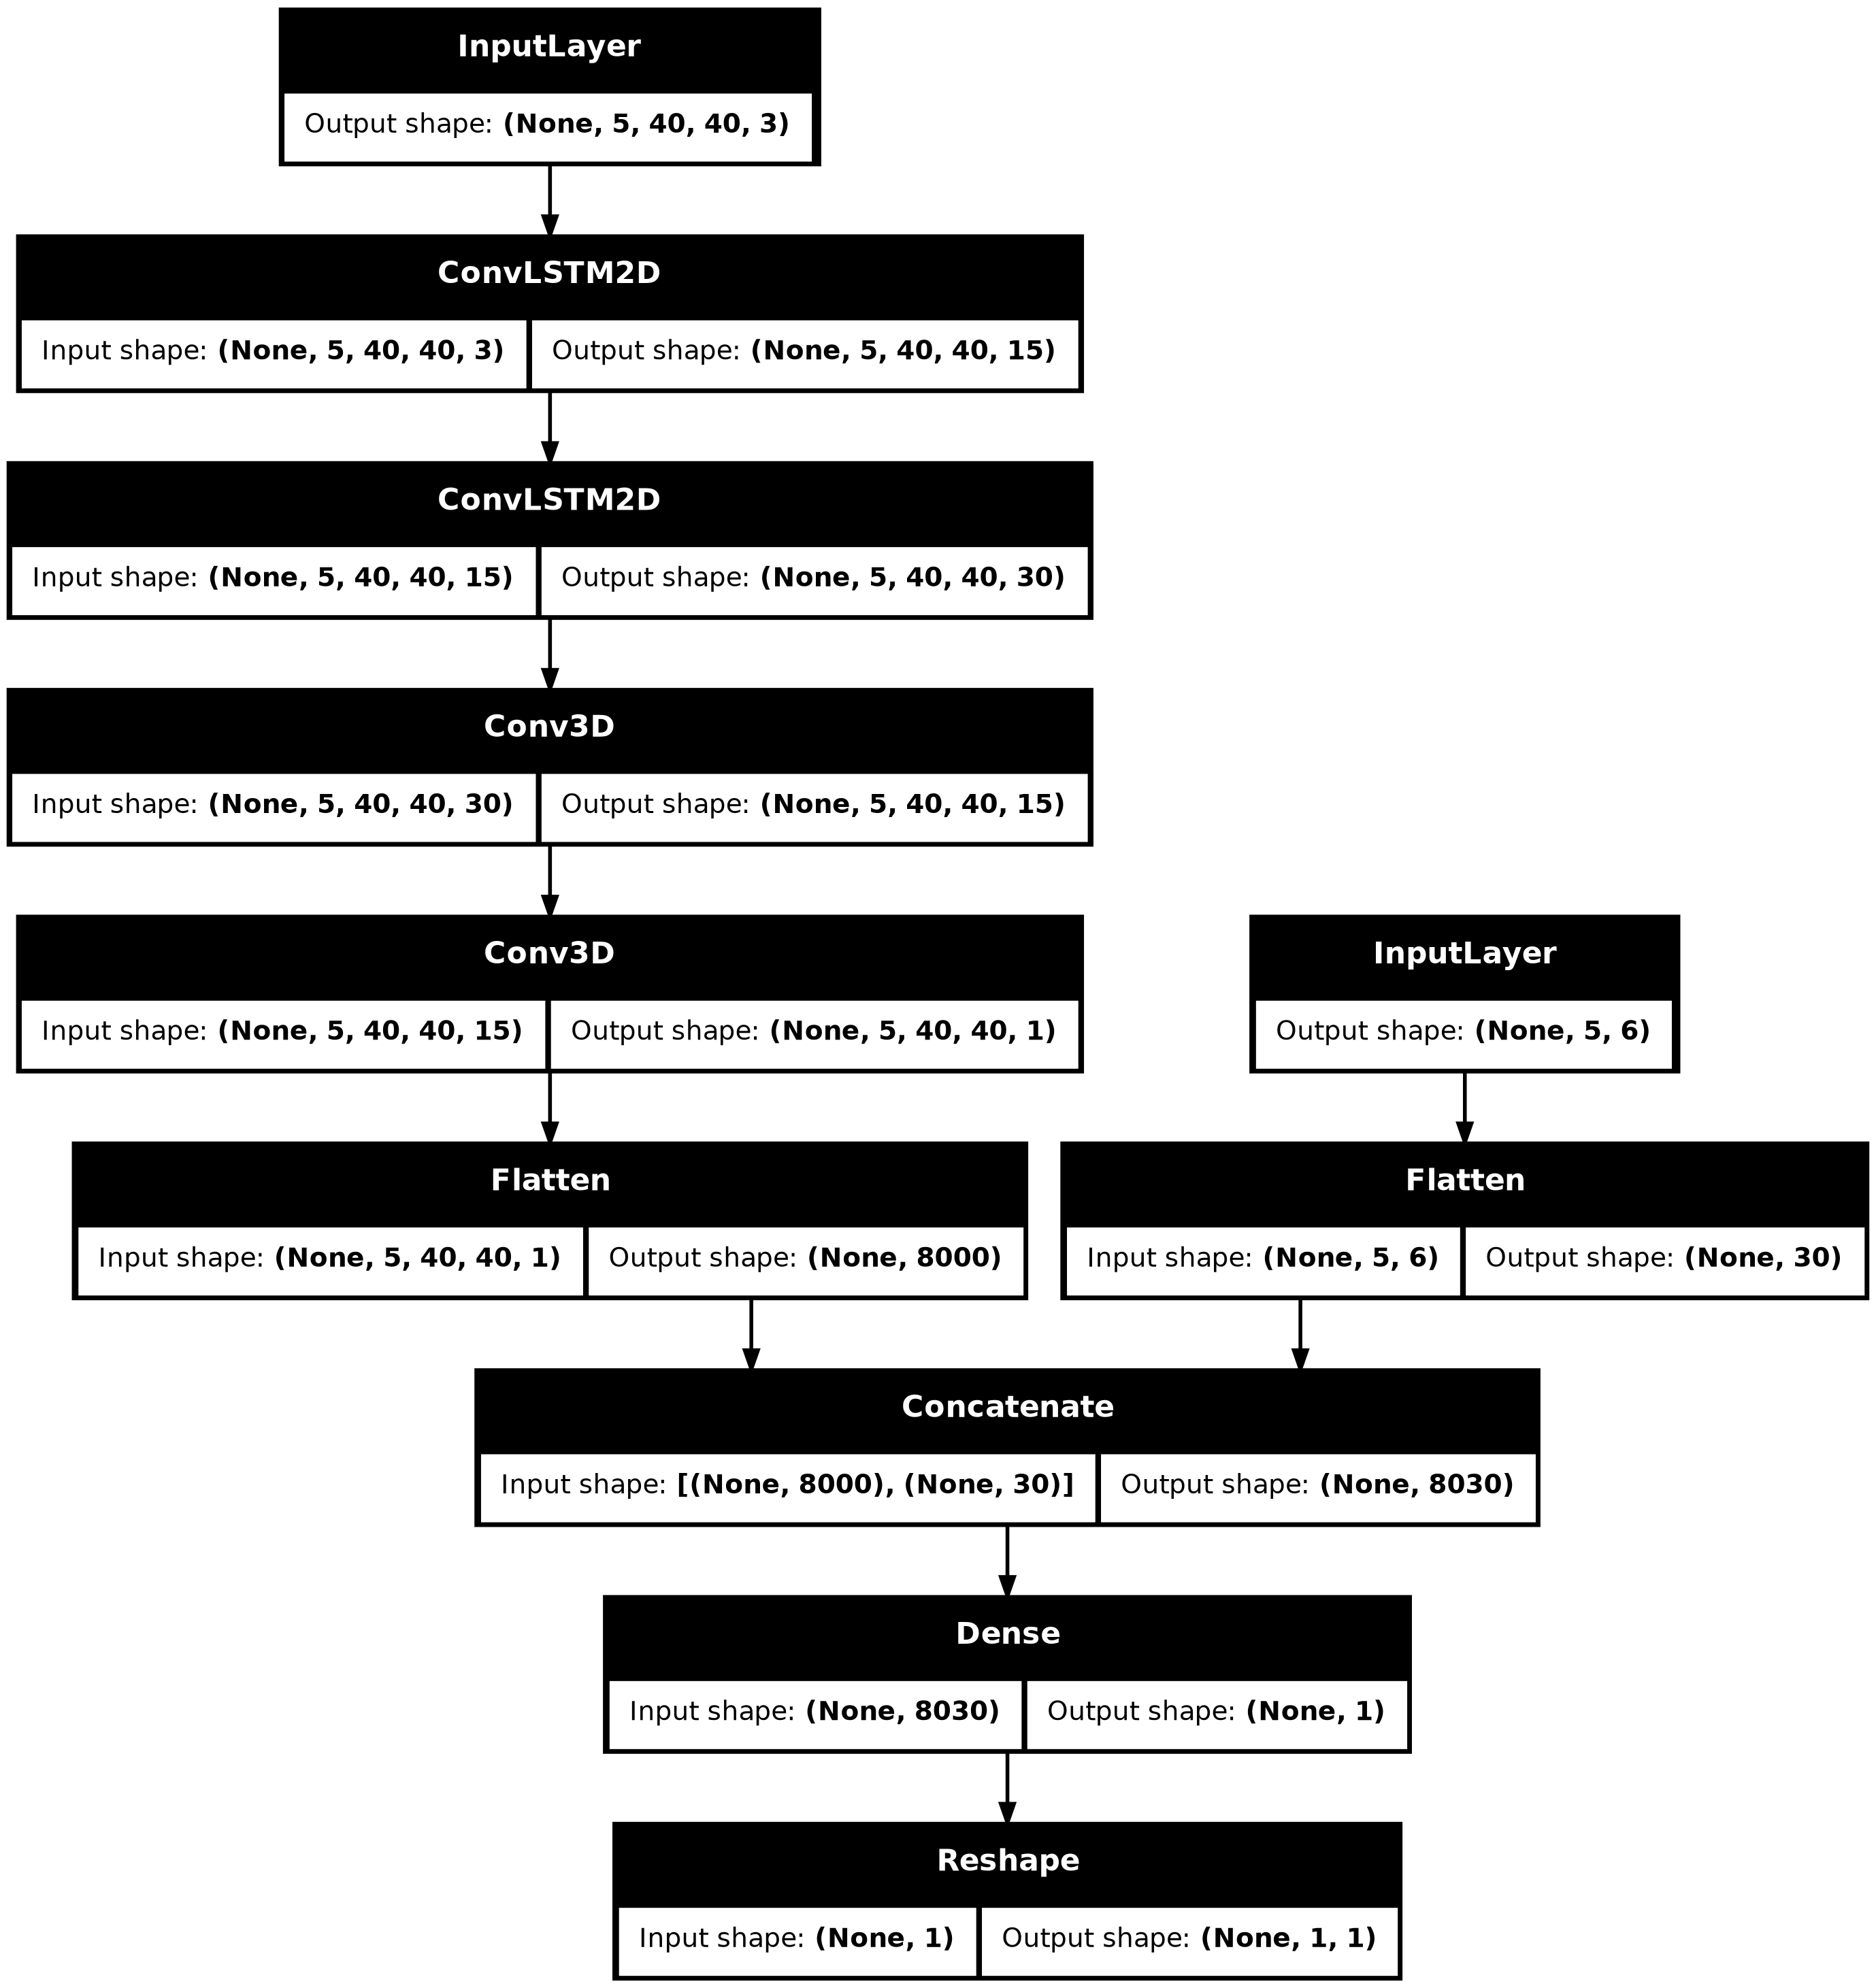

In [13]:
keras.utils.plot_model(model, "model_graph.png", show_shapes=True)

## Callbacks

In [14]:
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint, ReduceLROnPlateau
import os
import time

# tensorboard gradient logging callback
# at the end of an epoch, pass in a sample batch and calculate the gradients
class GradientLogger(tf.keras.callbacks.Callback):
    def __init__(self, log_dir, data_sample):
        super().__init__()
        self.writer = tf.summary.create_file_writer(log_dir)
        self.data_sample = data_sample  # A batch of (x, y) from your training data

    def on_epoch_end(self, epoch, logs=None):
        # log gradients
        x, y = self.data_sample

        with tf.GradientTape() as tape:
            loss = self.model.compute_loss(
                y=y, 
                y_pred=self.model(x, training=True)
            )

        gradients = tape.gradient(loss, self.model.trainable_weights)
        grad_norm = tf.linalg.global_norm(gradients)

        # plot gradients
        with self.writer.as_default():
            tf.summary.scalar("gradient_norm/global", grad_norm, step=epoch)
            
            for weight, grad in zip(self.model.trainable_weights, gradients):
                if grad is not None:
                    tf.summary.histogram(f"gradients/{weight.name}", grad, step=epoch)
            self.writer.flush()

# tensorboard callback setup
def get_run_logdir(
    root_logdir, 
    run_id=time.strftime("run_%Y_%m_%d-%H_%M_%S")
):
    return os.path.join(root_logdir, run_id)
    
run_logdir = get_run_logdir(
    root_logdir=os.path.join(os.curdir, "my_logs"),
    run_id="default"
)
tensorboard_callback = TensorBoard(run_logdir, histogram_freq=1)
#gradient_logging_callback = GradientLogger(run_logdir, data_sample=(X_test_scaled[:32], Y_test[:32]))

# model checkpoint callback setup
model_checkpoint_callback = ModelCheckpoint(
    filepath=model_checkpoint_file,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

# lr scheduling callback setup
lr_scheduling_callback = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
)

# early stopping callback
early_stopping_callback = EarlyStopping(
    monitor='val_loss', 
    patience=20,
    restore_best_weights=True,
)

# define list of callbacks we're gonna use
callbacks = [
    # early_stopping_callback,
    model_checkpoint_callback,
    # lr_scheduling_callback,
    # #tensorboard_callback,
    # #gradient_logging_callback
]

## Training

In [15]:
history = model.fit(
        x=[X_train, X_train_2],
        y=Y_train,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=([X_valid, X_valid_2], Y_valid),
        callbacks=callbacks
    )

Epoch 1/100


I0000 00:00:1753552679.259526    8276 service.cc:146] XLA service 0x28584440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1753552679.259672    8276 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 5080, Compute Capability 12.0
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


 10/384 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 10.6460 

I0000 00:00:1753552681.551745    8276 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


382/384 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.2557 

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


384/384 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 6.2471

'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


384/384 ━━━━━━━━━━━━━━━━━━━━ 16s 27ms/step - loss: 6.2428 - val_loss: 3.4128
Epoch 2/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 3.3928 - val_loss: 3.2180
Epoch 3/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 3.1328 - val_loss: 2.9439
Epoch 4/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 2.9734 - val_loss: 3.0692
Epoch 5/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 2.8818 - val_loss: 2.7099
Epoch 6/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 2.7480 - val_loss: 2.8240
Epoch 7/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 2.6774 - val_loss: 3.0503
Epoch 8/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 2.5168 - val_loss: 3.3980
Epoch 9/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 2.4078 - val_loss: 3.2767
Epoch 10/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 2.3102 - val_loss: 2.4147
Epoch 11/100
384/384 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 2.2721 - val_loss: 2.4057
Epoch 12/100
384/384 ━━━━━━━━━━━━━━━━━━━━

# Model Evaluation


Evaluating model


'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)
'+ptx85' is not a recognized feature for this target (ignoring feature)


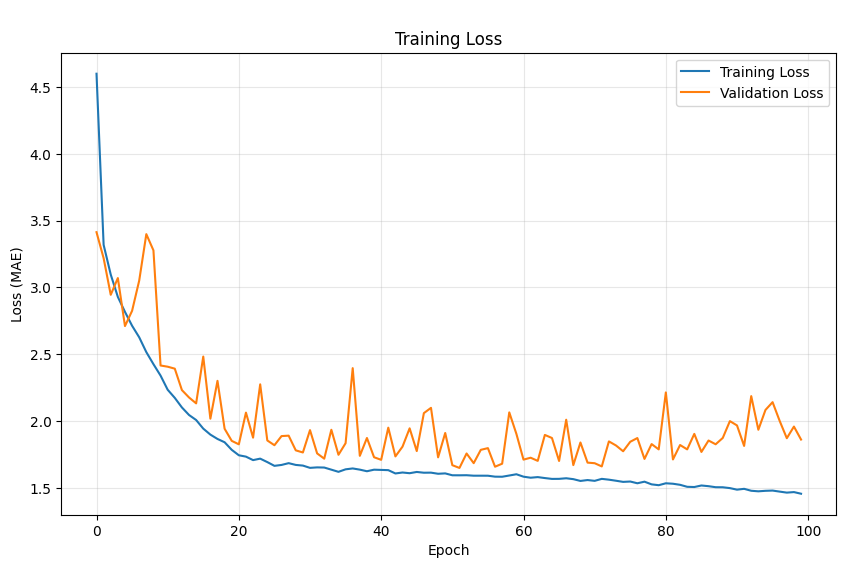

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from datetime import datetime

# Evaluate model
print(f"\nEvaluating model")
#model = keras.saving.load_model(model_checkpoint_file)
y_pred = model.predict([X_test, X_test_2], verbose=0)

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title(f'\nTraining Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MAE)')
plt.grid(True, alpha=0.3)
plt.show()

In [17]:
from libs.plotting import *
import pandas as pd

results = [
    [
        rmse(Y_test[1:], Y_test[:-1]), 
        rmse(y_pred, Y_test),
        rmse(y_pred[1:], Y_test[:-1]),
    ],
    [
        nrmse(Y_test[1:], Y_test[:-1]),
        nrmse(y_pred, Y_test),        
        nrmse(y_pred[1:], Y_test[:-1]),

    ],
    [        
        mae(Y_test[1:], Y_test[:-1]),
        mae(y_pred, Y_test),
        mae(y_pred[1:], Y_test[:-1]),
    ],
    [
        r2_score(Y_test[:-1], Y_test[1:]),
        r2_score(Y_test, y_pred),
        r2_score(Y_test[:-1], y_pred[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,2.338641,2.293106,1.696301
NRMSE,16.802139,16.479274,12.187202
MAE,1.462357,1.536989,1.117535
R2,0.867632,0.872794,0.930359


In [18]:
# first-frame error
results = [
    [
        rmse(Y_test[1:, 0], Y_test[:-1, 0]), 
        rmse(y_pred[:, 0], Y_test[:, 0]),
        rmse(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        nrmse(Y_test[1:, 0], Y_test[:-1, 0]),
        nrmse(y_pred[:, 0], Y_test[:, 0]),        
        nrmse(y_pred[1:, 0], Y_test[:-1, 0]),

    ],
    [        
        mae(Y_test[1:, 0], Y_test[:-1, 0]),
        mae(y_pred[:, 0], Y_test[:, 0]),
        mae(y_pred[1:, 0], Y_test[:-1, 0]),
    ],
    [
        r2_score(Y_test[:-1, 0], Y_test[1:, 0]),
        r2_score(Y_test[:, 0], y_pred[:, 0]),
        r2_score(Y_test[:-1, 0], y_pred[1:, 0]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,2.338641,2.293106,1.696301
NRMSE,16.802139,16.479274,12.187202
MAE,1.462357,1.536989,1.117535
R2,0.867632,0.872794,0.930359


In [19]:
# clean up dead sensors; more accurate, also allows us to use mape
from sklearn.metrics import mean_absolute_percentage_error as mape
#mape_err = mape(np.squeeze(cleaned_test), np.squeeze(cleaned_pred))

dead_sens = np.where(Y_test == 0)
print(f"{len(dead_sens[0])} samples containing dead sensors removed")

cleaned_test = np.delete(Y_test, dead_sens, 0)
cleaned_pred = np.delete(y_pred, dead_sens, 0)

results = [
    [
        rmse(cleaned_test[1:], cleaned_test[:-1]), 
        rmse(cleaned_pred, cleaned_test),
        rmse(cleaned_pred[1:], cleaned_test[:-1]),
    ],
    [
        nrmse(cleaned_test[1:], cleaned_test[:-1]),
        nrmse(cleaned_pred, cleaned_test),        
        nrmse(cleaned_pred[1:], cleaned_test[:-1]),

    ],
    [        
        mae(cleaned_test[1:], cleaned_test[:-1]),
        mae(cleaned_pred, cleaned_test),
        mae(cleaned_pred[1:], cleaned_test[:-1]),
    ],
    [
        mape(np.squeeze(cleaned_test[:-1]), np.squeeze(cleaned_test[1:]))*100,
        mape(np.squeeze(cleaned_test), np.squeeze(cleaned_pred))*100,
        mape(np.squeeze(cleaned_test[:-1]), np.squeeze(cleaned_pred[1:]))*100,
    ],
    [
        r2_score(cleaned_test[:-1], cleaned_test[1:]),
        r2_score(cleaned_test, cleaned_pred),
        r2_score(cleaned_test[:-1], cleaned_pred[1:]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

15 samples containing dead sensors removed


,Baseline Error,Model Error,Model Error Shifted
RMSE,1.999741,2.017001,1.456650
NRMSE,14.283395,14.410459,10.404304
MAE,1.414116,1.475446,1.071742
MAPE,10.834828,11.602301,8.497538
R2,0.901122,0.899457,0.947536


In [20]:
# first frame results
results = [
    [
        rmse(cleaned_test[1:, 0], cleaned_test[:-1, 0]), 
        rmse(cleaned_pred[:, 0], cleaned_test[:, 0]),
        rmse(cleaned_pred[1:, 0], cleaned_test[:-1, 0]),
    ],
    [
        nrmse(cleaned_test[1:, 0], cleaned_test[:-1, 0]),
        nrmse(cleaned_pred[:, 0], cleaned_test[:, 0]),        
        nrmse(cleaned_pred[1:, 0], cleaned_test[:-1, 0]),

    ],
    [        
        mae(cleaned_test[1:, 0], cleaned_test[:-1, 0]),
        mae(cleaned_pred[:, 0], cleaned_test[:, 0]),
        mae(cleaned_pred[1:, 0], cleaned_test[:-1, 0]),
    ],
    [
        mape(np.squeeze(cleaned_test[:-1, 0]), np.squeeze(cleaned_test[1:, 0]))*100,
        mape(np.squeeze(cleaned_test[:, 0]), np.squeeze(cleaned_pred[:, 0]))*100,
        mape(np.squeeze(cleaned_test[:-1, 0]), np.squeeze(cleaned_pred[1:, 0]))*100,
    ],
    [
        r2_score(cleaned_test[:-1, 0], cleaned_test[1:, 0]),
        r2_score(cleaned_test[:, 0], cleaned_pred[:, 0]),
        r2_score(cleaned_test[:-1, 0], cleaned_pred[1:, 0]),
    ]
]

df = pd.DataFrame(
    results, 
    columns=['Baseline Error', 'Model Error', 'Model Error Shifted'], 
    index=['RMSE', 'NRMSE', 'MAE', 'MAPE', 'R2']
)
display(df)

,Baseline Error,Model Error,Model Error Shifted
RMSE,1.999741,2.017001,1.456650
NRMSE,14.283395,14.410459,10.404304
MAE,1.414116,1.475446,1.071742
MAPE,10.834828,11.602301,8.497538
R2,0.901122,0.899457,0.947536


📊 TEMPORAL DEGRADATION ANALYSIS
This measures how ConvLSTM prediction accuracy degrades as we predict further into the future.
Later time steps are inherently harder to predict due to error accumulation.



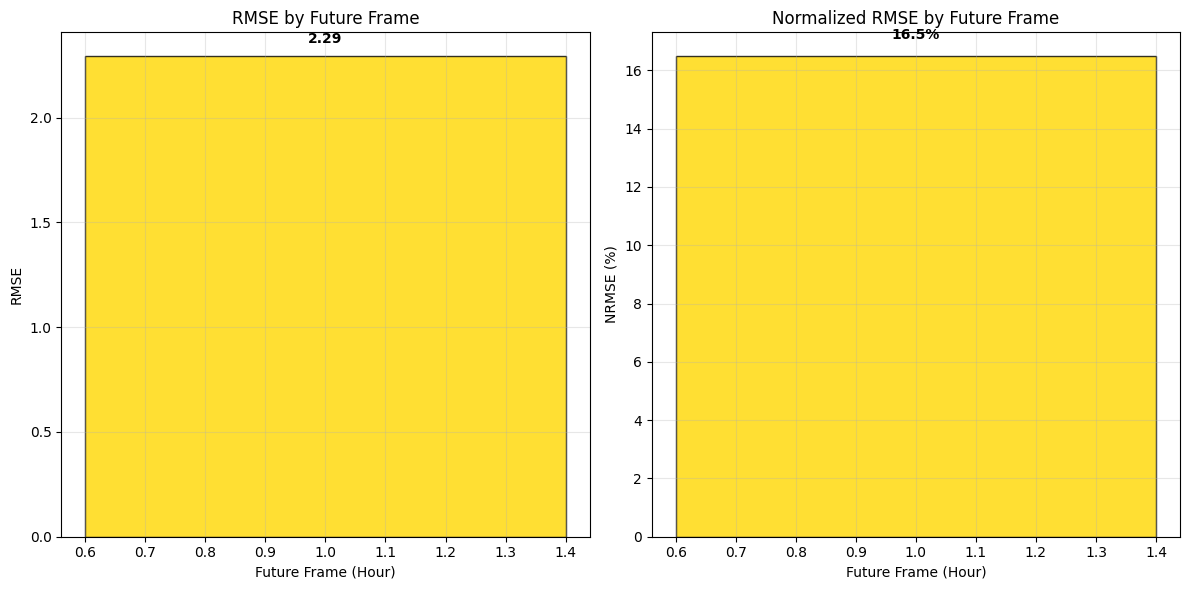


📊 FRAME-BY-FRAME RMSE SUMMARY:
Hour 1: RMSE = 2.293 (16.5%)
📋 DETAILED CONVLSTM PERFORMANCE BREAKDOWN
This section provides comprehensive metrics for each prediction horizon and monitoring station.
Essential for identifying specific model weaknesses and guiding improvements.

📋 DETAILED FRAME-BY-FRAME STATISTICS

🕐 HOUR 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────────────────────────
┌─ OVERALL PERFORMANCE ──────────────────────────────────────────────────────────┐
│ RMSE:  2.293 (16.5%)   │   MAE:  1.537   │   R²:  0.873              │
└────────────────────────────────────────────────────────────────────────────────┘

📍 BY SENSOR LOCATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
Location                 │RMSE   │%     │MAE    │R²     │Actual │Pred  
─────────────────────────┼───────┼──────┼───────┼───────┼───────┼──────
Long Beach Signal Hill   │2.29   │16.5  %│1.54   │0.873  │

In [21]:
plot_frame_by_frame_rmse(y_pred, Y_test)
print_detailed_frame_stats(y_pred, Y_test, sensor_names)

📊 TEMPORAL DEGRADATION ANALYSIS
This measures how ConvLSTM prediction accuracy degrades as we predict further into the future.
Later time steps are inherently harder to predict due to error accumulation.



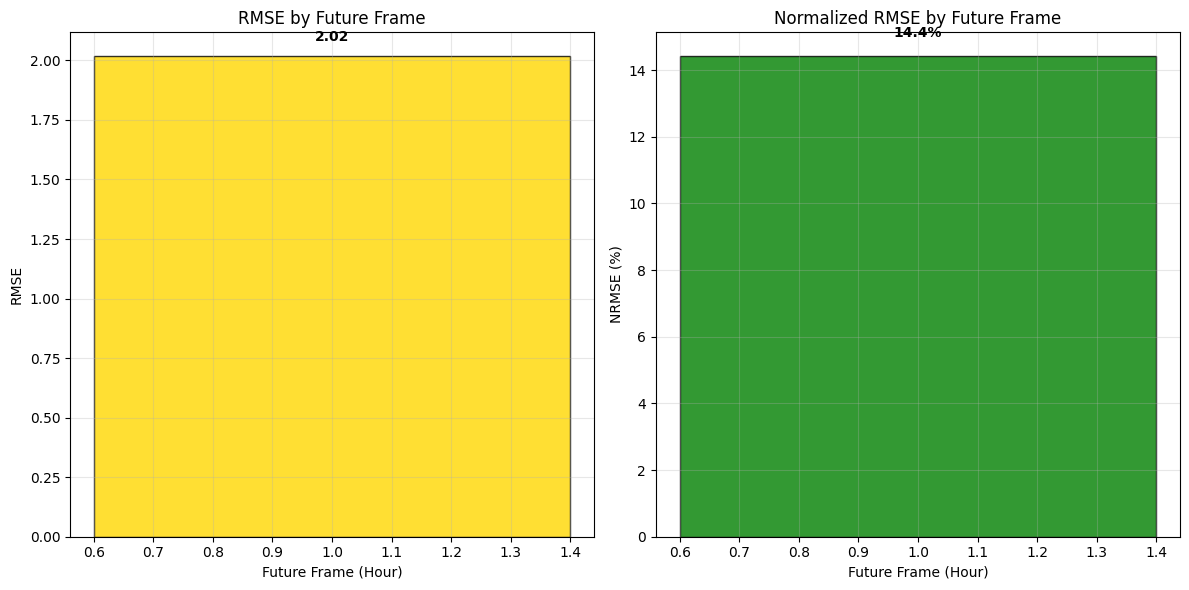


📊 FRAME-BY-FRAME RMSE SUMMARY:
Hour 1: RMSE = 2.017 (14.4%)
📋 DETAILED CONVLSTM PERFORMANCE BREAKDOWN
This section provides comprehensive metrics for each prediction horizon and monitoring station.
Essential for identifying specific model weaknesses and guiding improvements.

📋 DETAILED FRAME-BY-FRAME STATISTICS

🕐 HOUR 1 ANALYSIS
────────────────────────────────────────────────────────────────────────────────────────────────────
┌─ OVERALL PERFORMANCE ──────────────────────────────────────────────────────────┐
│ RMSE:  2.017 (14.4%)   │   MAE:  1.475   │   R²:  0.899              │
└────────────────────────────────────────────────────────────────────────────────┘

📍 BY SENSOR LOCATION:
────────────────────────────────────────────────────────────────────────────────────────────────────
Location                 │RMSE   │%     │MAE    │R²     │Actual │Pred  
─────────────────────────┼───────┼──────┼───────┼───────┼───────┼──────
Long Beach Signal Hill   │2.02   │14.4  %│1.48   │0.899  │

In [22]:
plot_frame_by_frame_rmse(cleaned_pred, cleaned_test)
print_detailed_frame_stats(cleaned_pred, cleaned_test, sensor_names)

# Plots

## Snapshot plots - first frame

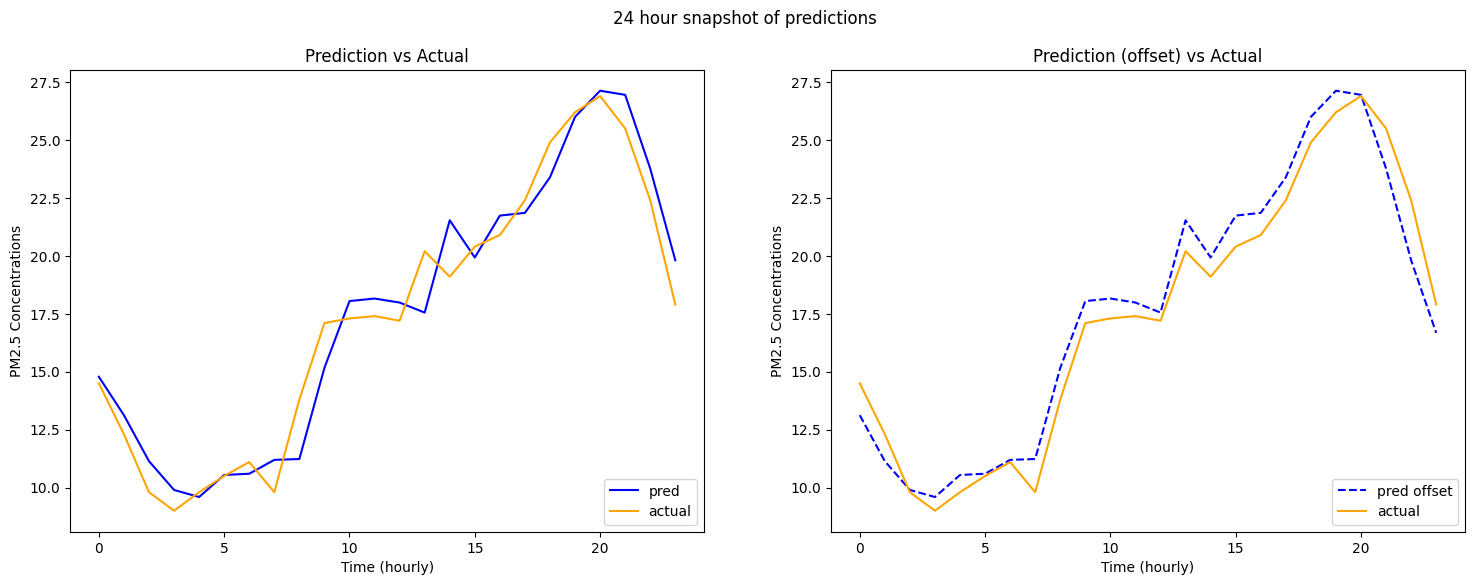

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle("24 hour snapshot of predictions")

axes[0].plot(y_pred[1000:1024, 0], color='blue', label='pred')
axes[0].plot(Y_test[1000:1024, 0], color='orange', label='actual')
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].legend(loc="lower right")
axes[0].set_title("Prediction vs Actual")

axes[1].plot(y_pred[1001:1025, 0], color='blue', linestyle='--', label='pred offset')
axes[1].plot(Y_test[1000:1024, 0], color='orange', label='actual')
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].legend(loc="lower right")
axes[1].set_title("Prediction (offset) vs Actual")

plt.show()

[]

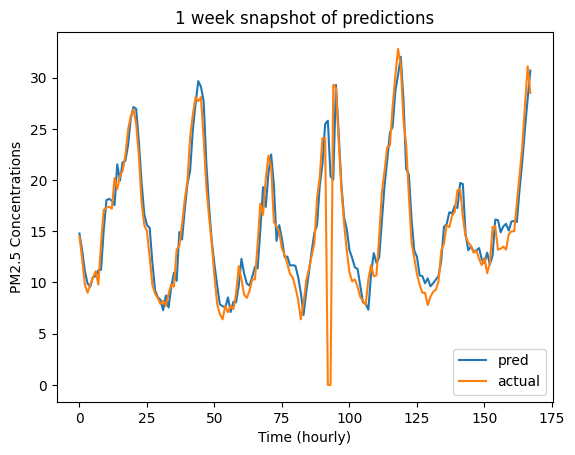

In [24]:
plt.plot(y_pred[1000:1168, 0], label='pred')
plt.plot(Y_test[1000:1168, 0], label='actual')
plt.xlabel("Time (hourly)")
plt.ylabel("PM2.5 Concentrations")
plt.title("1 week snapshot of predictions")
plt.legend(loc="lower right")
plt.plot()

In [25]:
best_week = float('inf')
worst_week = float('-inf')
best_idx, worst_idx = 0, 0

worst_week_cleaned = float('-inf')
worst_idx_cleaned = 0
for i in range(len(y_pred) - 168):
    err = nrmse(y_pred[i:i+168, 0], Y_test[i:i+168, 0])
    if err < best_week:
        best_week = err
        best_idx = i
    if err > worst_week:
        worst_week = err
        worst_idx = i

for i in range(len(cleaned_pred) - 168):
    cleaned_err = nrmse(cleaned_pred[i:i+168], cleaned_test[i:i+168])
    if cleaned_err > worst_week_cleaned:
        worst_week_cleaned = cleaned_err
        worst_idx_cleaned = i

print(len(y_pred), len(cleaned_pred))

2631 2615


In [26]:
# train-valid-test
dates = pd.date_range(START_DATE, END_DATE, freq='h')[:len(Y_train) + len(Y_valid) + len(Y_test)]
print(dates.shape)
y_test_start_idx = len(Y_train) + len(Y_valid)
print(dates[y_test_start_idx:].shape) # 2631

cleaned_test_dates = np.delete(dates[y_test_start_idx:], dead_sens, 0)
cleaned_test_dates.shape

(17535,)
(2631,)


(2615,)

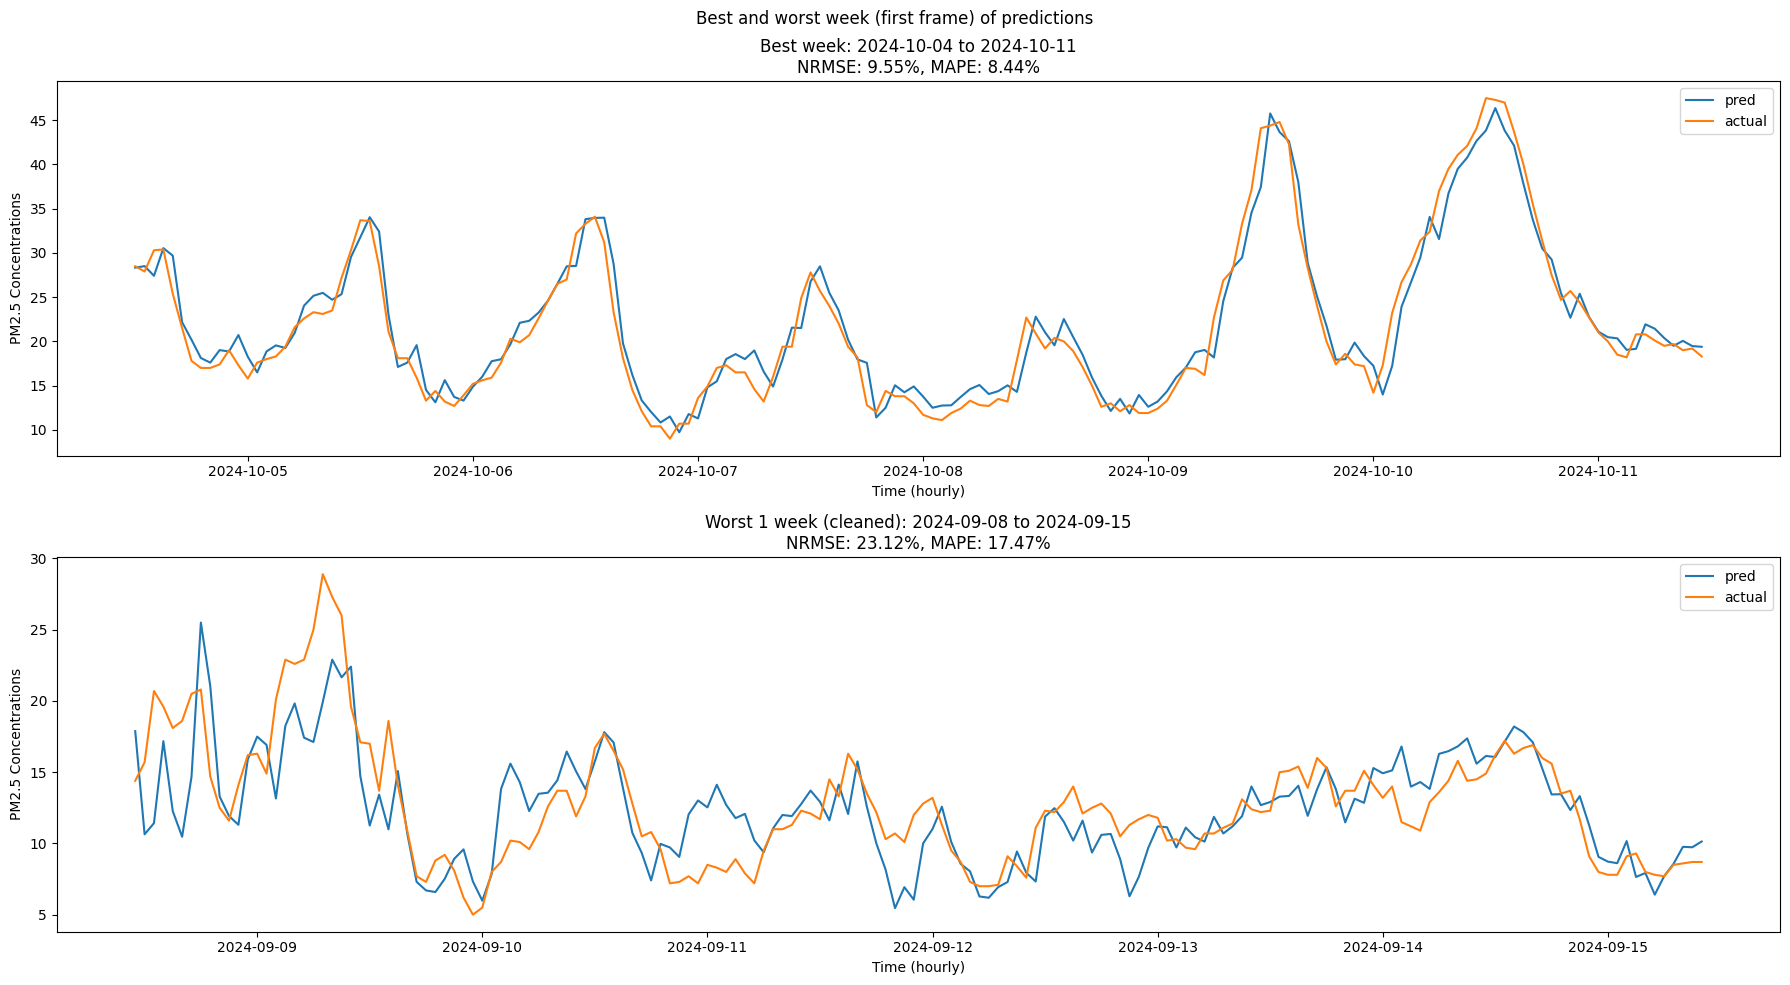

In [27]:
fig, axes = plt.subplots(2, 1, figsize=(18, 10))
fig.suptitle('Best and worst week (first frame) of predictions')

# best week
axes[0].plot(
    dates[y_test_start_idx + best_idx : y_test_start_idx + best_idx + 168],
    y_pred[best_idx:best_idx+168, 0],
    label='pred'
)
axes[0].plot(
    dates[y_test_start_idx + best_idx : y_test_start_idx + best_idx + 168],
    Y_test[best_idx:best_idx+168, 0],
    label='actual'
)
axes[0].set_xlabel("Time (hourly)")
axes[0].set_ylabel("PM2.5 Concentrations")
axes[0].set_title(
    f"Best week: {dates[y_test_start_idx + best_idx].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + best_idx + 168].strftime('%Y-%m-%d')}\n"
    f"NRMSE: {best_week:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test[best_idx : best_idx + 168]), 
        np.squeeze(y_pred[best_idx : best_idx + 168])
    )*100:.2f}%"
)
axes[0].legend(loc="upper right")

# worst week (cleaned)
axes[1].plot(
    #dates[y_test_start_idx + worst_idx_cleaned : y_test_start_idx + worst_idx_cleaned + 168],
    cleaned_test_dates[worst_idx_cleaned : worst_idx_cleaned + 168],
    cleaned_pred[worst_idx_cleaned:worst_idx_cleaned+168, 0], 
    label='pred'
)
axes[1].plot(
    #dates[y_test_start_idx + worst_idx_cleaned : y_test_start_idx + worst_idx_cleaned + 168],
    cleaned_test_dates[worst_idx_cleaned : worst_idx_cleaned + 168],
    cleaned_test[worst_idx_cleaned:worst_idx_cleaned+168, 0],
    label='actual'
)
axes[1].set_xlabel("Time (hourly)")
axes[1].set_ylabel("PM2.5 Concentrations")
axes[1].set_title(
    f"Worst 1 week (cleaned): {cleaned_test_dates[worst_idx_cleaned].strftime('%Y-%m-%d')} to "
    f"{dates[y_test_start_idx + worst_idx_cleaned + 168].strftime('%Y-%m-%d')}\n"
    f"NRMSE: {worst_week_cleaned:.2f}%, "
    f"MAPE: {mape(
        np.squeeze(Y_test[worst_idx_cleaned : worst_idx_cleaned + 168]), 
        np.squeeze(y_pred[worst_idx_cleaned : worst_idx_cleaned + 168])
    )*100:.2f}%"
)
axes[1].legend(loc="upper right")

plt.tight_layout()
plt.show()

## Rolling avg plots

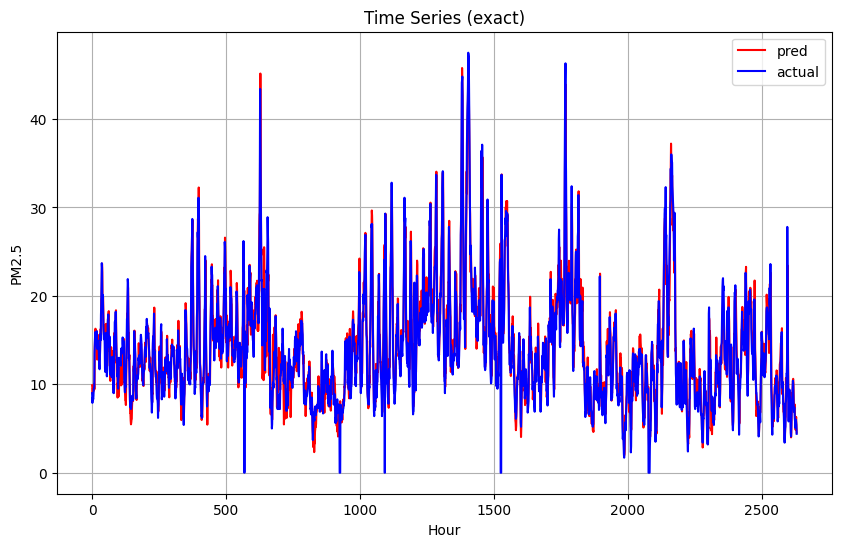

In [28]:
series_pred = pd.Series(np.squeeze(y_pred[:, 0]))
series_test = pd.Series(np.squeeze(Y_test[:, 0]))

plt.figure(figsize=(10, 6))
plt.plot(series_pred, label=f'pred', color='red')
plt.plot(series_test, label=f'actual', color='blue')
plt.title('Time Series (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

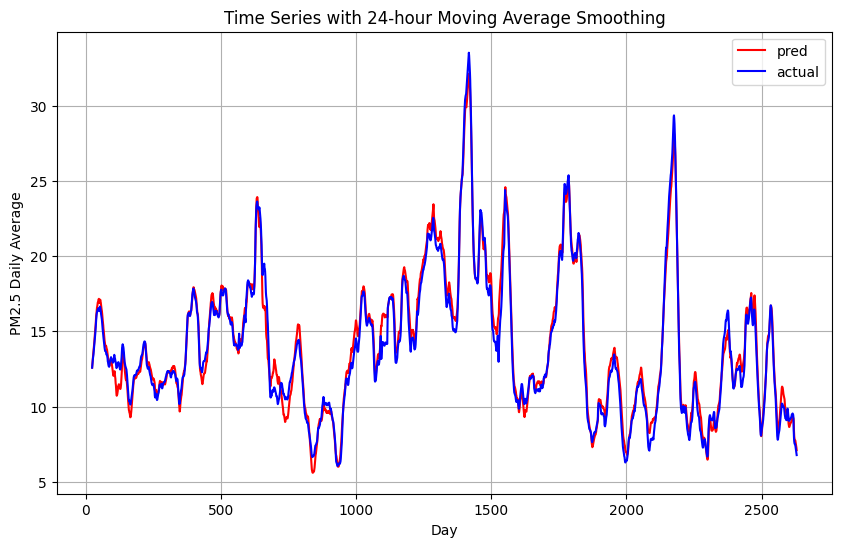

In [29]:
import pandas as pd

window_size = 24 # daily average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with 24-hour Moving Average Smoothing')
plt.xlabel('Day')
plt.ylabel('PM2.5 Daily Average')
plt.legend()
plt.grid(True)
plt.show()

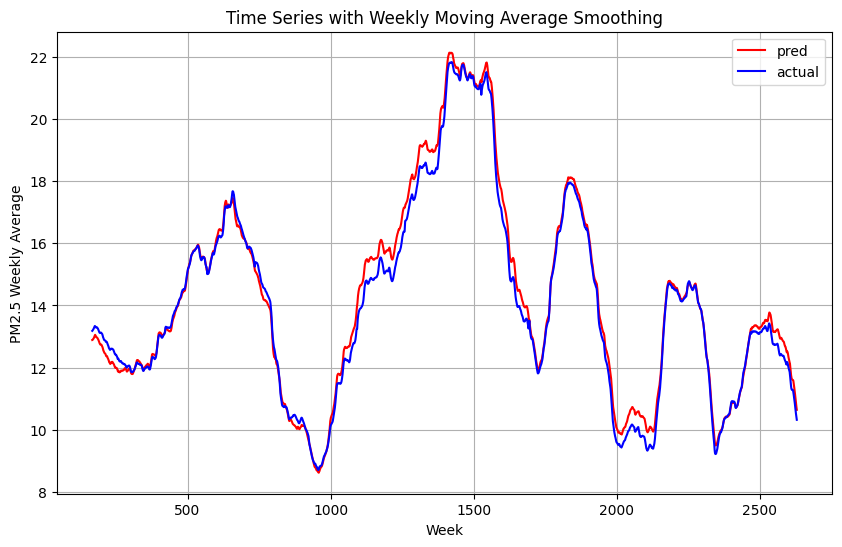

In [30]:
window_size = 168 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with Weekly Moving Average Smoothing')
plt.xlabel('Week')
plt.ylabel('PM2.5 Weekly Average')
plt.legend()
plt.grid(True)
plt.show()

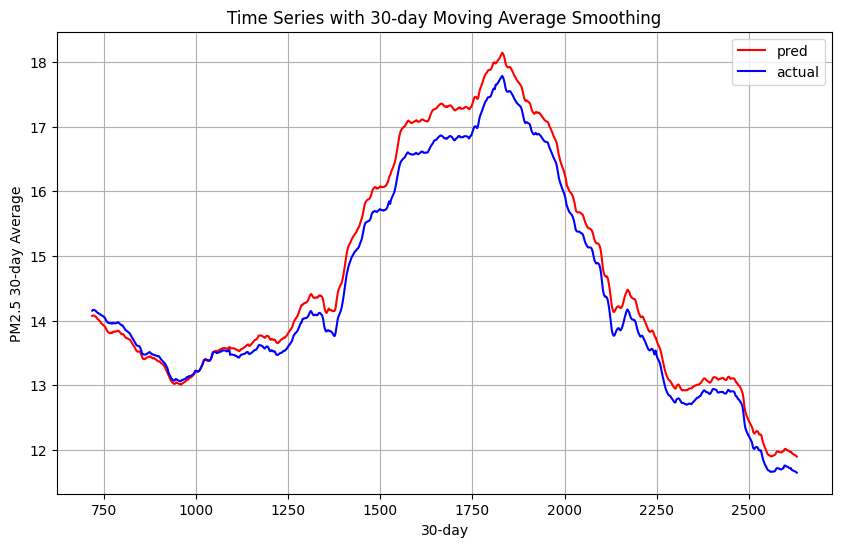

In [31]:
window_size = 720 # weekly average
smoothed_pred = series_pred.rolling(window=window_size).mean()
smoothed_test = series_test.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_pred, label=f'pred', color='red')
plt.plot(smoothed_test, label=f'actual', color='blue')
plt.title('Time Series with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()

## Error plots (first frame)

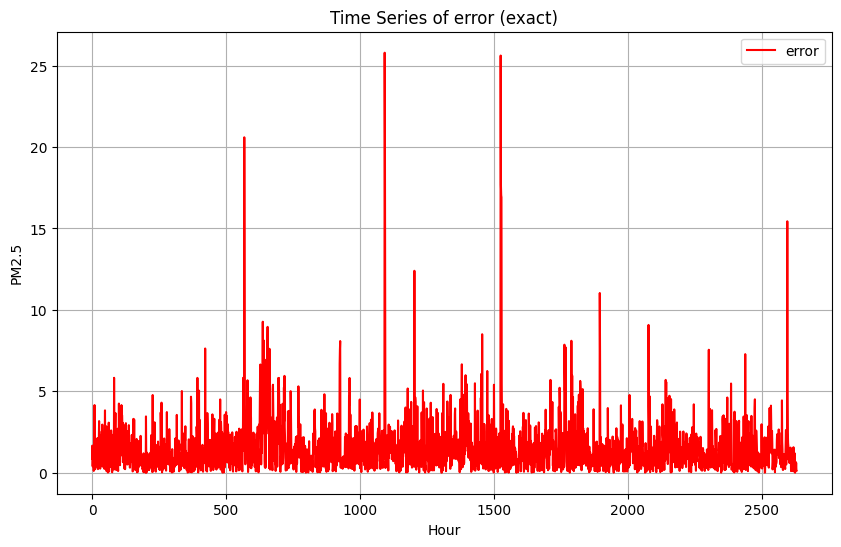

In [32]:
series = pd.Series(np.squeeze(np.abs(y_pred[:, 0] - Y_test[:, 0])))
plt.figure(figsize=(10, 6))
plt.plot(series, label=f'error', color='red')
plt.title('Time Series of error (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

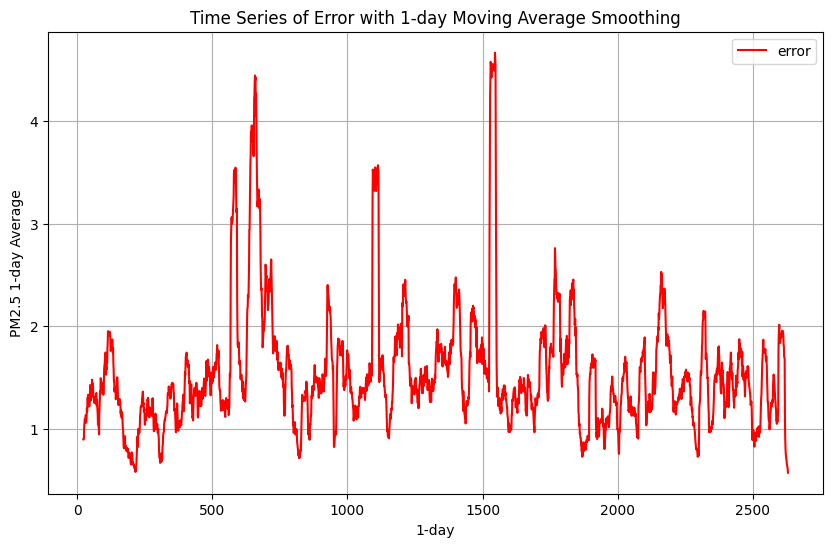

In [33]:
window_size = 24 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 1-day Moving Average Smoothing')
plt.xlabel('1-day')
plt.ylabel('PM2.5 1-day Average')
plt.legend()
plt.grid(True)
plt.show()

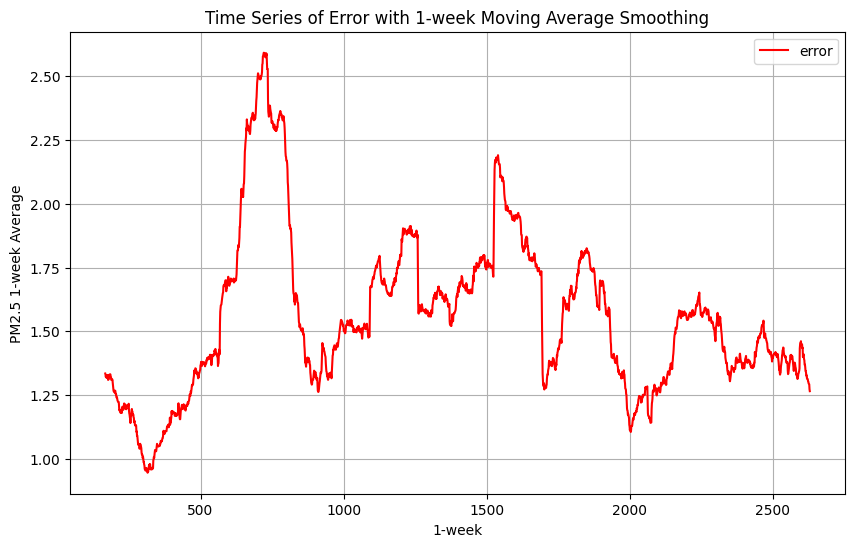

In [34]:
window_size = 168 # weekly average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 1-week Moving Average Smoothing')
plt.xlabel('1-week')
plt.ylabel('PM2.5 1-week Average')
plt.legend()
plt.grid(True)
plt.show()

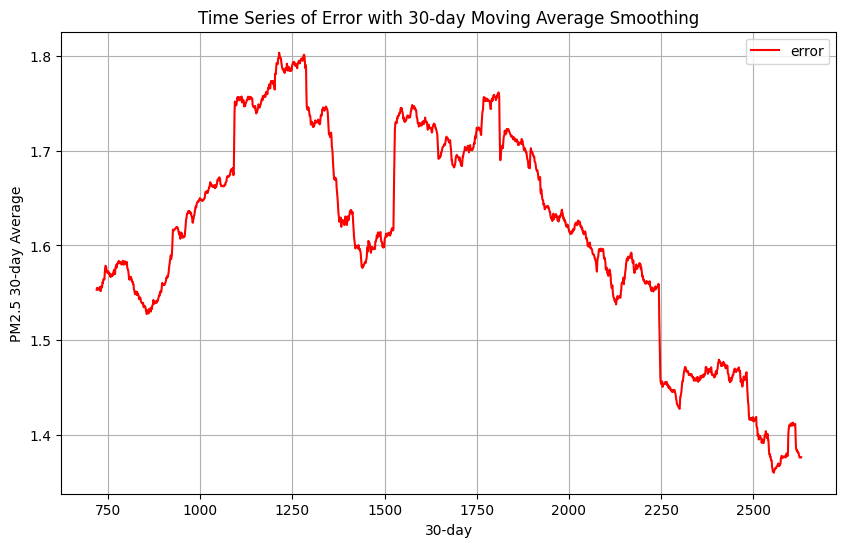

In [35]:
window_size = 720 # 30-day average
smoothed_series = series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='red')
plt.title('Time Series of Error with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()

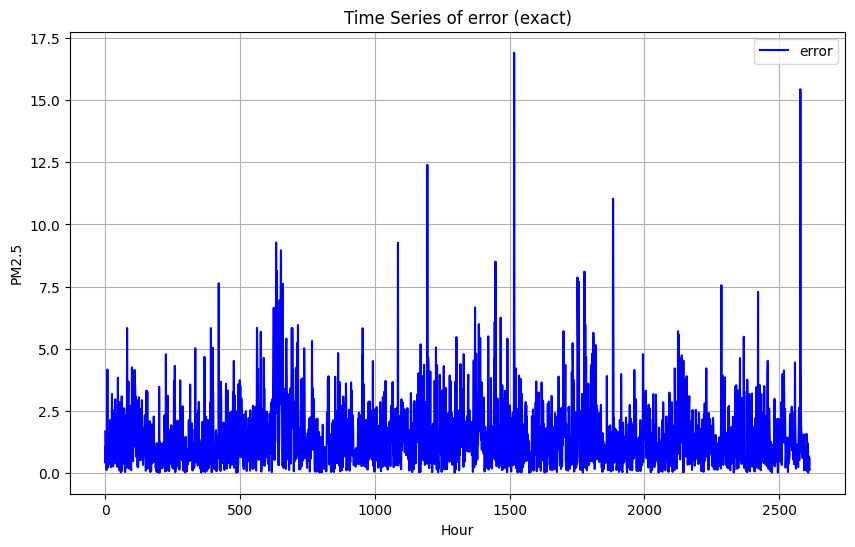

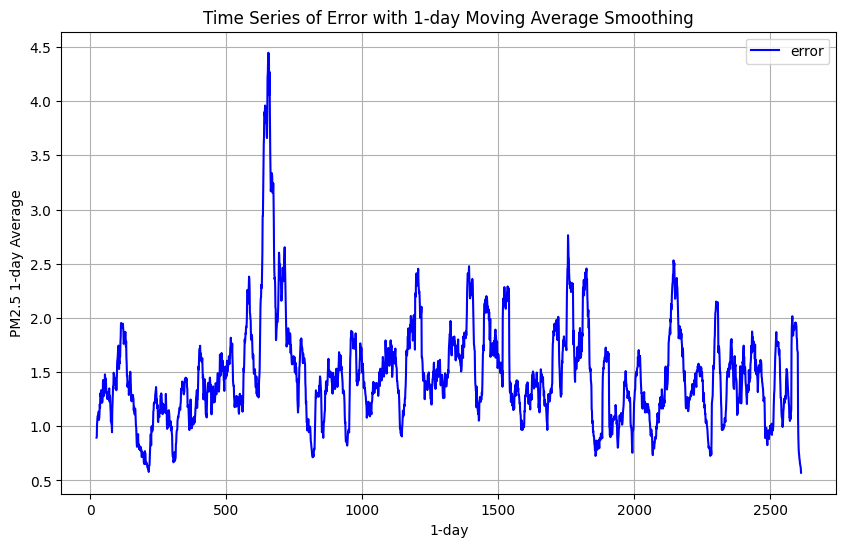

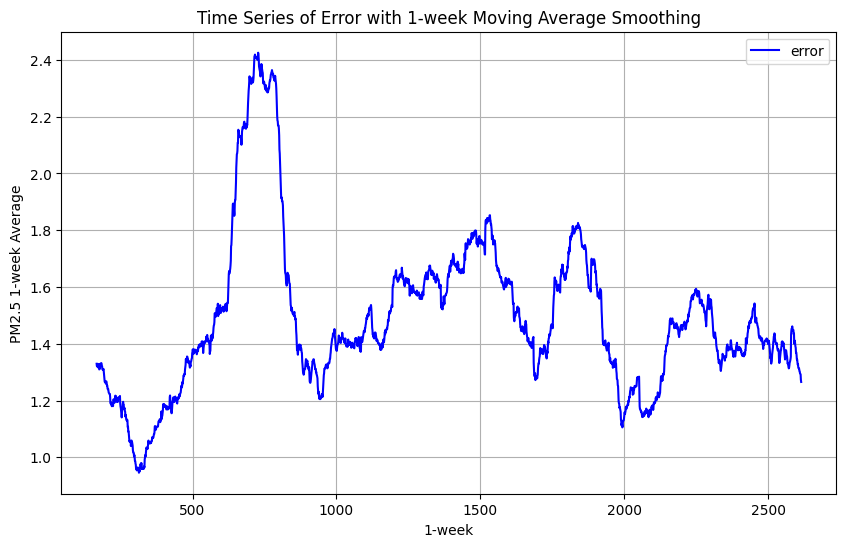

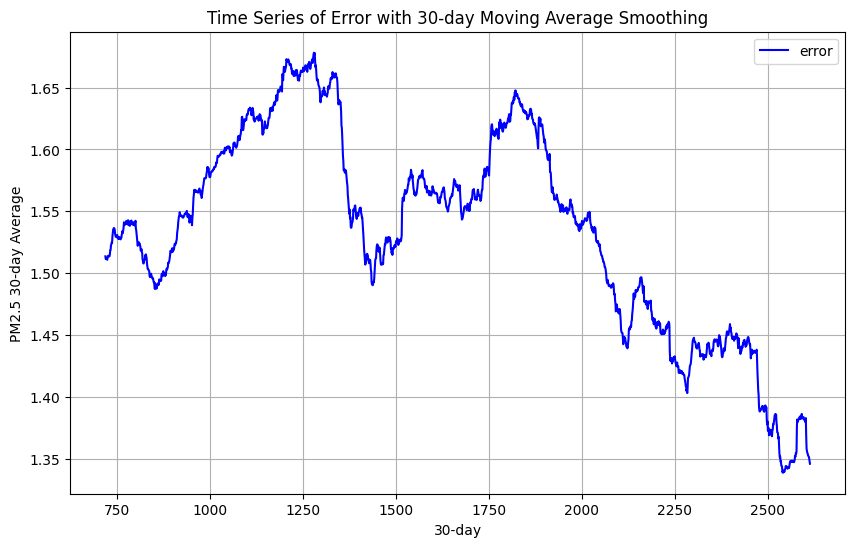

In [36]:
# cleaned plots
cleaned_series = pd.Series(np.squeeze(np.abs(cleaned_pred[:, 0] - cleaned_test[:, 0])))
plt.figure(figsize=(10, 6))
plt.plot(cleaned_series, label=f'error', color='blue')
plt.title('Time Series of error (exact)')
plt.xlabel('Hour')
plt.ylabel('PM2.5')
plt.legend()
plt.grid(True)
plt.show()

window_size = 24 # daily average
smoothed_series = cleaned_series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='blue')
plt.title('Time Series of Error with 1-day Moving Average Smoothing')
plt.xlabel('1-day')
plt.ylabel('PM2.5 1-day Average')
plt.legend()
plt.grid(True)
plt.show()

window_size = 168 # weekly average
smoothed_series = cleaned_series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='blue')
plt.title('Time Series of Error with 1-week Moving Average Smoothing')
plt.xlabel('1-week')
plt.ylabel('PM2.5 1-week Average')
plt.legend()
plt.grid(True)
plt.show()

window_size = 720 # 30-day average
smoothed_series = cleaned_series.rolling(window=window_size).mean()

plt.figure(figsize=(10, 6))
plt.plot(smoothed_series, label=f'error', color='blue')
plt.title('Time Series of Error with 30-day Moving Average Smoothing')
plt.xlabel('30-day')
plt.ylabel('PM2.5 30-day Average')
plt.legend()
plt.grid(True)
plt.show()